In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import timm   # For EfficientNet-B3
import matplotlib.pyplot as plt


c:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\eye_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())
else:
    print("No GPU detected — training will be extremely slow.")


CUDA available: True
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
CUDA device count: 1


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# BASE DATASET PATH
BASE_PATH = r"C:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\dataset2"

TRAIN_CSV = os.path.join(BASE_PATH, "train.csv")
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train_images")

# Load the CSV file
df = pd.read_csv(TRAIN_CSV)

print("CSV Loaded Successfully!")
print(df.head())

# Add the full image path
def construct_path(image_id):
    jpg_path = os.path.join(TRAIN_IMG_DIR, f"{image_id}.jpg")
    png_path = os.path.join(TRAIN_IMG_DIR, f"{image_id}.png")
    
    if os.path.exists(jpg_path):
        return jpg_path
    elif os.path.exists(png_path):
        return png_path
    else:
        return None

df["image_path"] = df["id_code"].apply(construct_path)

print("\nSample After Adding Image Paths:")
print(df.head())

# Check if any paths are missing
missing_paths = df["image_path"].isna().sum()
print(f"\nMissing image paths: {missing_paths}")

# Drop rows with missing images
df = df.dropna(subset=["image_path"]).reset_index(drop=True)

# Train / Validation Split (Stratified — VERY important)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["diagnosis"]
)

print("\nDataset Split Completed:")
print("Training Samples:", len(train_df))
print("Validation Samples:", len(val_df))


CSV Loaded Successfully!
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Sample After Adding Image Paths:
        id_code  diagnosis                                         image_path
0  000c1434d8d7          2  C:\Users\Adarsh Sharma\OneDrive\Desktop\major ...
1  001639a390f0          4  C:\Users\Adarsh Sharma\OneDrive\Desktop\major ...
2  0024cdab0c1e          1  C:\Users\Adarsh Sharma\OneDrive\Desktop\major ...
3  002c21358ce6          0  C:\Users\Adarsh Sharma\OneDrive\Desktop\major ...
4  005b95c28852          0  C:\Users\Adarsh Sharma\OneDrive\Desktop\major ...

Missing image paths: 0

Dataset Split Completed:
Training Samples: 2929
Validation Samples: 733


In [5]:
import cv2
import numpy as np

IMG_SIZE = 384

def crop_black_borders(img):
    """
    Removes black borders around the retina.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    img_cropped = img[y:y+h, x:x+w]
    return img_cropped

def circle_crop(img):
    """
    Applies a circular crop around the retina.
    """
    h, w = img.shape[:2]
    radius = min(h, w) // 2
    center = (w//2, h//2)
    
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, center, radius, (255), -1)
    
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    return img_masked

def apply_clahe(img):
    """
    Applies CLAHE to each channel separately.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    
    lab = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def preprocess_fundus(image_path):
    """
    Full preprocessing pipeline for APTOS/EyePACS retina images.
    Output: Cleaned + resized image (NumPy array).
    """
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Remove black borders
    img = crop_black_borders(img)

    # 2. Resize to stable size before circle crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # 3. Circular crop
    img = circle_crop(img)

    # 4. CLAHE
    img = apply_clahe(img)

    # 5. Slight Gaussian smoothing
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # 6. Enhance brightness (blend)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 30), -4, 128)

    # 7. Resize final
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    return img


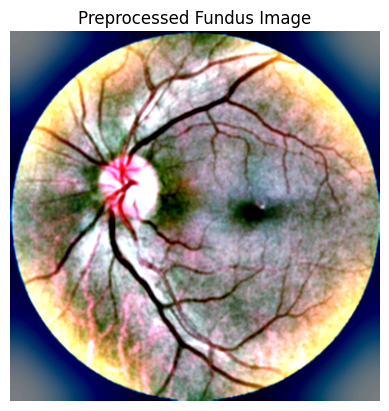

In [6]:
sample_path = train_df.iloc[0]["image_path"]
clean_img = preprocess_fundus(sample_path)

plt.imshow(clean_img)
plt.title("Preprocessed Fundus Image")
plt.axis("off")
plt.show()


In [7]:
import albumentations as A

train_transforms = A.Compose([
    
    # Geometric augmentations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.ShiftScaleRotate(
        shift_limit=0.05, 
        scale_limit=0.1, 
        rotate_limit=15, 
        p=0.7
    ),

    # Color and brightness
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.7
    ),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),

    # Noise and blur
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),

    # Advanced color augmentation
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),

    # Random erasing-style augmentation
    A.CoarseDropout(
        max_holes=8,
        max_height=32,
        max_width=32,
        p=0.5
    ),
])


In [8]:
valid_transforms = A.Compose([
    A.Resize(384, 384)
])


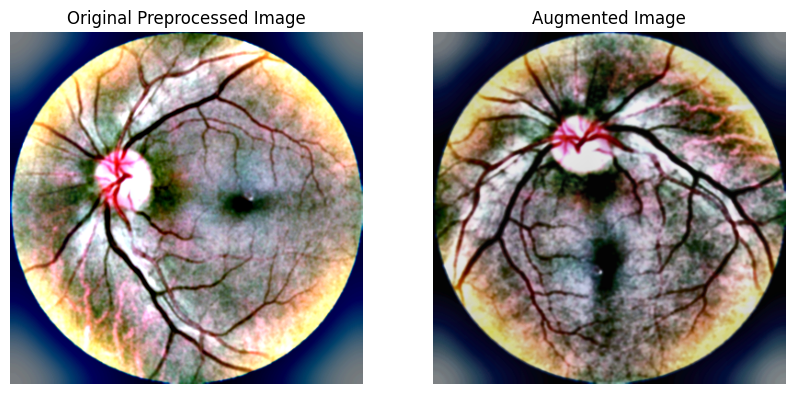

In [9]:
sample_path = train_df.iloc[0]["image_path"]
img = preprocess_fundus(sample_path)

augmented = train_transforms(image=img)["image"]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Preprocessed Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(augmented)
plt.title("Augmented Image")
plt.axis("off")

plt.show()


In [10]:
from torch.utils.data import Dataset
import torch

class APTOSDataset(Dataset):
    def __init__(self, df, transforms=None, is_train=True):
        """
        df: DataFrame with image_path + diagnosis
        transforms: Albumentations transform pipeline
        is_train: training or validation mode
        """
        self.df = df
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 1. Get image path and label
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = row["diagnosis"]

        # 2. Preprocess retina image
        img = preprocess_fundus(img_path)  # returns RGB NumPy

        # 3. Apply augmentations (training only)
        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented["image"]

        # 4. Normalize to [0,1]
        img = img.astype("float32") / 255.0

        # 5. Convert HWC → CHW for PyTorch
        #np.transpose(img, (0, 1, 2))       # WRONG (we fix below)
        img = np.transpose(img, (2, 0, 1))  # CHW format
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return img_tensor, label_tensor


In [11]:
class APTOSDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = row["diagnosis"]

        # Preprocess fundus image
        img = preprocess_fundus(img_path)  # RGB NumPy array

        # Apply augmentation if available
        if self.transforms:
            img = self.transforms(image=img)["image"]

        # Normalize
        img = img.astype("float32") / 255.0

        # Convert to CHW format for PyTorch
        img = np.transpose(img, (2, 0, 1))

        # Convert to Tensor
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return img_tensor, label_tensor


In [12]:
train_dataset = APTOSDataset(train_df, transforms=train_transforms)
val_dataset   = APTOSDataset(val_df, transforms=valid_transforms)


In [13]:
img, label = train_dataset[0]
print("Image shape:", img.shape)
print("Label:", label)


Image shape: torch.Size([3, 384, 384])
Label: tensor(0.)


In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = 4    # Adjust based on CPU

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Train loader batches:", len(train_loader))
print("Validation loader batches:", len(val_loader))


Train loader batches: 184
Validation loader batches: 46


In [15]:
import os

PREP_PATH = r"C:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\dataset2_preprocessed"

os.makedirs(os.path.join(PREP_PATH, "train"), exist_ok=True)
os.makedirs(os.path.join(PREP_PATH, "valid"), exist_ok=True)

print("Preprocessed folders created.")


Preprocessed folders created.


In [ ]:
# from tqdm import tqdm
# import cv2

# def save_preprocessed(df, split_name):
#     output_dir = os.path.join(PREP_PATH, split_name)
#     os.makedirs(output_dir, exist_ok=True)

#     print(f"Processing {split_name} images...")

#     for idx, row in tqdm(df.iterrows(), total=len(df)):
#         img_path = row["image_path"]
#         img_id = row["id_code"]

#         try:
#             # Preprocess fundus image
#             img = preprocess_fundus(img_path)

#             # Save as JPG
#             save_path = os.path.join(output_dir, f"{img_id}.jpg")
#             cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

#         except Exception as e:
#             print(f"Error processing {img_path}: {e}")


# # Run preprocessing ONCE
# save_preprocessed(train_df, "train")
# save_preprocessed(val_df, "valid")


Processing train images...


  6%|▌         | 181/2929 [01:21<20:40,  2.21it/s]  


KeyboardInterrupt: 

In [19]:
train_df["image_path"] = train_df["id_code"].apply(
    lambda x: os.path.join(PREP_PATH, "train", f"{x}.jpg")
)

val_df["image_path"] = val_df["id_code"].apply(
    lambda x: os.path.join(PREP_PATH, "valid", f"{x}.jpg")
)


In [20]:
class APTOSDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = row["diagnosis"]

        # Load preprocessed image (FAST)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentation
        if self.transforms:
            img = self.transforms(image=img)["image"]

        # Normalize
        img = img.astype("float32") / 255.0

        # Convert to PyTorch format CHW
        img = np.transpose(img, (2, 0, 1))

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [21]:
train_dataset = APTOSDataset(train_df, transforms=train_transforms)
val_dataset   = APTOSDataset(val_df, transforms=valid_transforms)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [22]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [23]:
images, labels = next(iter(train_loader))
print("Loaded batch:", images.shape)


Loaded batch: torch.Size([16, 3, 384, 384])


In [24]:
print(train_df["image_path"].iloc[0])
print(os.path.exists(train_df["image_path"].iloc[0]))


C:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\dataset2_preprocessed\train\b2b79b37d314.jpg
True


In [25]:
import cv2

p = train_df["image_path"].iloc[0]
img = cv2.imread(p)

print("Loaded:", img is not None, "Shape:", None if img is None else img.shape)


Loaded: True Shape: (384, 384, 3)


In [26]:
train_dataset = APTOSDataset(train_df, transforms=None)
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0)
images, labels = next(iter(train_loader))
print("Worked:", images.shape)


Worked: torch.Size([4, 3, 384, 384])


In [27]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [28]:
images, labels = next(iter(train_loader))
print(images.shape)


torch.Size([16, 3, 384, 384])


In [29]:
print("Image path:", train_df["image_path"].iloc[0])
print("Exists:", os.path.exists(train_df["image_path"].iloc[0]))

img = cv2.imread(train_df["image_path"].iloc[0])
print("Loaded:", img is not None)


Image path: C:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\dataset2_preprocessed\train\b2b79b37d314.jpg
Exists: True
Loaded: True


In [30]:
import time

start = time.time()
images, labels = next(iter(train_loader))
end = time.time()

print("Time to load 1 batch:", end - start, "seconds")
print("Batch shape:", images.shape)


Time to load 1 batch: 0.07248663902282715 seconds
Batch shape: torch.Size([16, 3, 384, 384])


In [31]:
import timm
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNetB3Regression(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained EfficientNet-B3
        self.backbone = timm.create_model(
            'efficientnet_b3',
            pretrained=True,
            num_classes=0,       # remove classification head
            global_pool='avg'
        )

        # New regression head (1 output)
        self.fc = nn.Linear(self.backbone.num_features, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x  # raw regression output

model = EfficientNetB3Regression().to(device)

print("Model loaded on:", device)


Model loaded on: cuda


In [32]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels = train_df["diagnosis"].values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.4057, 1.9791, 0.7332, 3.8039, 2.4822], device='cuda:0')


In [33]:
import torch.nn.functional as F

def weighted_smooth_l1_loss(pred, target, class_weights):
    """
    pred: model output (batch_size, 1)
    target: labels 0–4
    class_weights: tensor([w0, w1, w2, w3, w4])
    """
    pred = pred.squeeze(1)

    # Compute standard smooth L1
    l1 = F.smooth_l1_loss(pred, target, reduction='none')

    # Gather weights for each sample
    weights = class_weights[target.long()]

    # Apply weights
    weighted_loss = l1 * weights

    return weighted_loss.mean()


In [34]:
import torch.optim as optim

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,        # good starting LR
    weight_decay=1e-4
)


In [35]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # we monitor QWK (maximize)
    factor=0.5,          # reduce LR by half
    patience=2,          # wait 2 epochs
    min_lr=1e-6,
    verbose=True
)


c:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\eye_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
from sklearn.metrics import cohen_kappa_score

def quadratic_kappa(y_true, y_pred):
    """
    y_true: list of ground truth labels
    y_pred: list of continuous predictions -> rounded to nearest integer
    """
    y_pred_rounded = np.clip(np.round(y_pred), 0, 4).astype(int)
    return cohen_kappa_score(y_true, y_pred_rounded, weights="quadratic")


In [37]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
labels = train_df["diagnosis"].values

class_weights_np = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)

# Weighted Smooth L1 loss
import torch.nn.functional as F

def weighted_smooth_l1_loss(pred, target, class_weights):
    pred = pred.squeeze(1)
    loss = F.smooth_l1_loss(pred, target, reduction='none')
    weights = class_weights[target.long()]
    return (loss * weights).mean()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# LR scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=True
)

# Kappa metric
from sklearn.metrics import cohen_kappa_score

def quadratic_kappa(y_true, y_pred):
    y_pred_rounded = np.clip(np.round(y_pred), 0, 4).astype(int)
    return cohen_kappa_score(y_true, y_pred_rounded, weights="quadratic")


Class Weights: tensor([0.4057, 1.9791, 0.7332, 3.8039, 2.4822], device='cuda:0')


c:\Users\Adarsh Sharma\OneDrive\Desktop\major projetc\X-EyeNet\eye_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
import torch
import numpy as np
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, class_weights):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)     # raw regression output
        loss = weighted_smooth_l1_loss(outputs, labels, class_weights)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = F.smooth_l1_loss(outputs.squeeze(1), labels, reduction='mean')
            total_loss += loss.item()

            all_preds.extend(outputs.squeeze(1).cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Compute Quadratic Weighted Kappa
    kappa = quadratic_kappa(
        np.array(all_targets),
        np.array(all_preds)
    )

    return total_loss / len(loader), kappa


In [39]:
EPOCHS = 10
best_kappa = -1
MODEL_PATH = "efficientnetb3_best.pth"

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, class_weights)
    val_loss, val_kappa = validate_one_epoch(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Kappa:  {val_kappa:.4f}")

    # Step the scheduler based on Kappa
    scheduler.step(val_kappa)

    # Save best model
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"BEST MODEL SAVED (Kappa = {best_kappa:.4f})")



===== Epoch 1/10 =====


Train Loss: 0.4551
Val Loss:   0.1869
Val Kappa:  0.8508
BEST MODEL SAVED (Kappa = 0.8508)

===== Epoch 2/10 =====


Train Loss: 0.1937
Val Loss:   0.2153
Val Kappa:  0.8581
BEST MODEL SAVED (Kappa = 0.8581)

===== Epoch 3/10 =====


Train Loss: 0.1317
Val Loss:   0.2017
Val Kappa:  0.8438

===== Epoch 4/10 =====


Train Loss: 0.1062
Val Loss:   0.1752
Val Kappa:  0.8729
BEST MODEL SAVED (Kappa = 0.8729)

===== Epoch 5/10 =====


Train Loss: 0.1080
Val Loss:   0.1813
Val Kappa:  0.8639

===== Epoch 6/10 =====


Train Loss: 0.0723
Val Loss:   0.1728
Val Kappa:  0.8773
BEST MODEL SAVED (Kappa = 0.8773)

===== Epoch 7/10 =====


Train Loss: 0.0541
Val Loss:   0.1752
Val Kappa:  0.8716

===== Epoch 8/10 =====


Train Loss: 0.0447
Val Loss:   0.1607
Val Kappa:  0.8675

===== Epoch 9/10 =====


Train Loss: 0.0525
Val Loss:   0.1618
Val Kappa:  0.8727

===== Epoch 10/10 =====


Train Loss: 0.0339
Val Loss:   0.1633
Val Kappa:  0.8836
BEST MODEL SAVED (Kappa = 0.8836)


In [49]:
train_losses = [0.4551, 0.1937, 0.1317, 0.1062, 0.1080, 0.0723, 0.0541, 0.0447, 0.0525, 0.0339]
val_losses   = [0.1869, 0.2153, 0.2017, 0.1752, 0.1813, 0.1728, 0.1752, 0.1607, 0.1618, 0.1633]
val_kappas   = [0.8508, 0.8581, 0.8438, 0.8729, 0.8639, 0.8773, 0.8716, 0.8675, 0.8727, 0.8836]



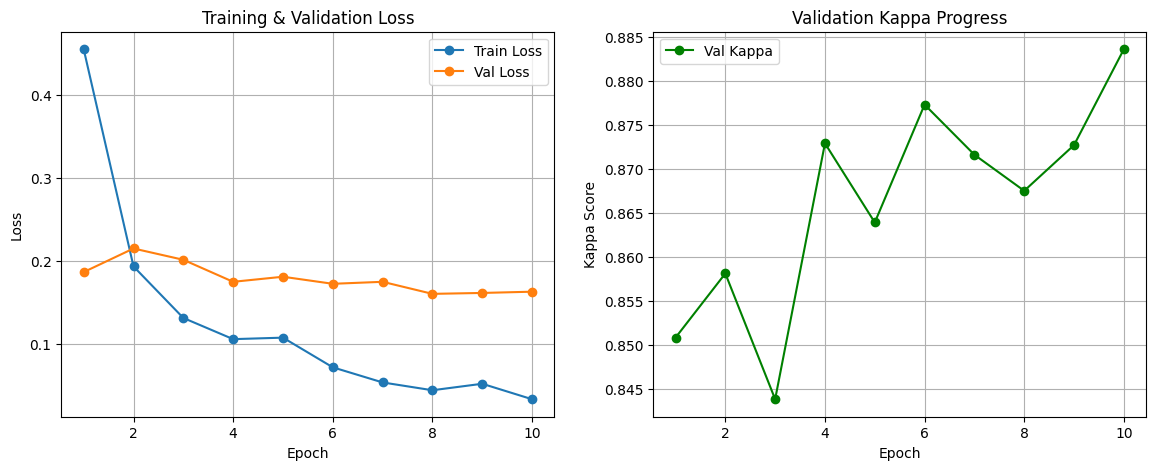

In [52]:
import matplotlib.pyplot as plt

# Assuming you stored logs inside lists during training
# If not, we will adapt this — but first try:

epochs = list(range(1, EPOCHS+1))

plt.figure(figsize=(14, 5))

# ---------------------
# LOSS PLOT
# ---------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# ---------------------
# KAPPA PLOT
# ---------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_kappas, label="Val Kappa", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Kappa Score")
plt.title("Validation Kappa Progress")
plt.legend()
plt.grid()

plt.show()


In [53]:
model = EfficientNetB3Regression().to(device)
model.load_state_dict(torch.load("efficientnetb3_best.pth", map_location=device))
model.eval()

print("Model loaded and ready for inference")


C:\Users\Adarsh Sharma\AppData\Local\Temp\ipykernel_52544\1959916300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("efficientnetb3_bes

Model loaded and ready for inference


In [54]:
def load_preprocessed_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = img.astype("float32") / 255.0
    img = np.transpose(img, (2, 0, 1))       # CHW
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)   # Add batch

    return img_tensor.to(device)

def predict_single(image_path):
    img_tensor = load_preprocessed_image(image_path)

    with torch.no_grad():
        output = model(img_tensor)
        pred_value = output.item()               # raw regression
        pred_class = int(np.clip(round(pred_value), 0, 4))

    return pred_value, pred_class


In [58]:
sample_path = val_df.iloc[0]["image_path"]
pred_value, pred_class = predict_single(sample_path)

print("Continuous Output:", pred_value)
print("Predicted Class:", pred_class)
print("Actual Class:", val_df.iloc[0]["diagnosis"])


Continuous Output: 0.13589581847190857
Predicted Class: 0
Actual Class: 0


In [59]:
def predict_batch(df, model, max_samples=10):
    results = []
    
    for i in range(min(max_samples, len(df))):
        path = df.iloc[i]["image_path"]
        actual = df.iloc[i]["diagnosis"]

        pred_val, pred_class = predict_single(path)

        results.append({
            "image": path,
            "actual": actual,
            "pred_value": pred_val,
            "pred_class": pred_class
        })

    return results


In [60]:
batch_results = predict_batch(val_df, model, max_samples=10)

for r in batch_results:
    print(r)


{'image': 'C:\\Users\\Adarsh Sharma\\OneDrive\\Desktop\\major projetc\\X-EyeNet\\dataset2_preprocessed\\valid\\6fe67fd7f5d1.jpg', 'actual': 0, 'pred_value': 0.13589581847190857, 'pred_class': 0}
{'image': 'C:\\Users\\Adarsh Sharma\\OneDrive\\Desktop\\major projetc\\X-EyeNet\\dataset2_preprocessed\\valid\\ef8c39eb9157.jpg', 'actual': 0, 'pred_value': 0.23488059639930725, 'pred_class': 0}
{'image': 'C:\\Users\\Adarsh Sharma\\OneDrive\\Desktop\\major projetc\\X-EyeNet\\dataset2_preprocessed\\valid\\61bbc11fe503.jpg', 'actual': 4, 'pred_value': 2.841217279434204, 'pred_class': 3}
{'image': 'C:\\Users\\Adarsh Sharma\\OneDrive\\Desktop\\major projetc\\X-EyeNet\\dataset2_preprocessed\\valid\\60edda7b4871.jpg', 'actual': 0, 'pred_value': 0.032177768647670746, 'pred_class': 0}
{'image': 'C:\\Users\\Adarsh Sharma\\OneDrive\\Desktop\\major projetc\\X-EyeNet\\dataset2_preprocessed\\valid\\d30d079e6f9a.jpg', 'actual': 0, 'pred_value': 0.3448428809642792, 'pred_class': 0}
{'image': 'C:\\Users\\Adars

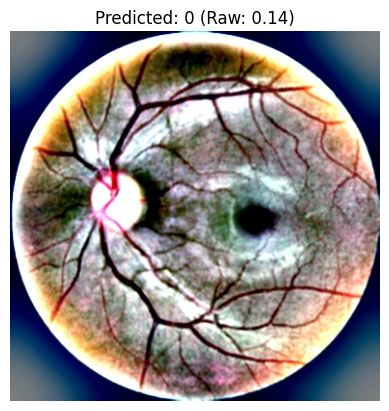

In [61]:
import matplotlib.pyplot as plt

def show_prediction(image_path):
    pred_val, pred_class = predict_single(image_path)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} (Raw: {pred_val:.2f})")
    plt.axis("off")
    plt.show()


# Example
show_prediction(val_df.iloc[0]["image_path"])


In [62]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(1)

        # Raw regression output
        preds = outputs.cpu().numpy()
        targets = labels.cpu().numpy()

        # Convert to class labels (0–4)
        preds_class = np.clip(np.round(preds), 0, 4).astype(int)

        all_preds.extend(preds_class)
        all_targets.extend(targets.astype(int))


Evaluating: 100%|██████████| 46/46 [01:20<00:00,  1.76s/it]


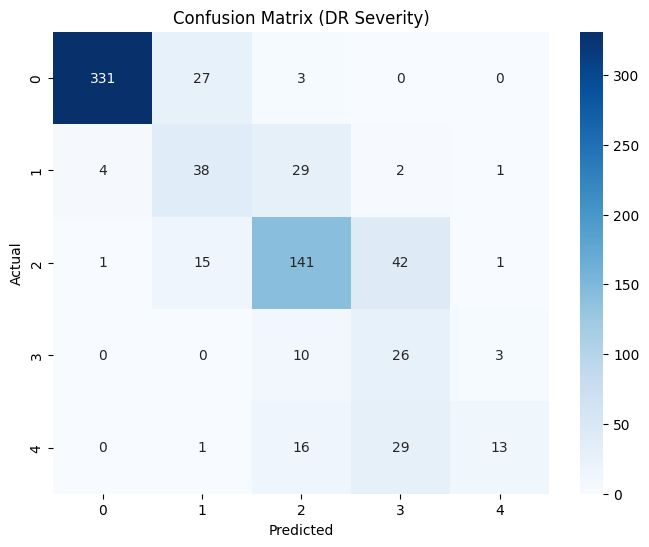

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (DR Severity)")
plt.show()


In [65]:
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_preds))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95       361
           1       0.47      0.51      0.49        74
           2       0.71      0.70      0.71       200
           3       0.26      0.67      0.38        39
           4       0.72      0.22      0.34        59

    accuracy                           0.75       733
   macro avg       0.63      0.60      0.57       733
weighted avg       0.80      0.75      0.76       733



In [66]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_targets, all_preds, weights="quadratic")
print("Final Validation Kappa:", kappa)


Final Validation Kappa: 0.8836255918995852


In [67]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook activation
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)


    def generate_heatmap(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)

        # For DR severity, backprop from the raw regression output
        loss = output.squeeze()

        # Backward pass
        self.model.zero_grad()
        loss.backward()

        # Gradients & activations
        grads = self.gradients           # shape: [B, C, H, W]
        acts  = self.activations         # shape: [B, C, H, W]

        # Global average pool the gradients
        weights = grads.mean(dim=(2,3), keepdim=True)

        # Weighted combination
        cam = (weights * acts).sum(dim=1)

        # Normalize CAM
        cam = cam.squeeze().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()

        return cam


In [68]:
target_layer = model.backbone.conv_head   # Last conv layer
gradcam = GradCAM(model, target_layer)


In [72]:
def generate_gradcam(image_path):
    # Load 384x384 preprocessed image for inference
    img_tensor = load_preprocessed_image(image_path)  # (1,3,384,384)

    # Grad-CAM heatmap (raw, small resolution)
    heatmap = gradcam.generate_heatmap(img_tensor)

    # Load retina image for visualization
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384,384))

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (384,384))

    # Convert to color map
    heatmap_color = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized),
        cv2.COLORMAP_JET
    )
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Overlay
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    return img, heatmap_color, overlay


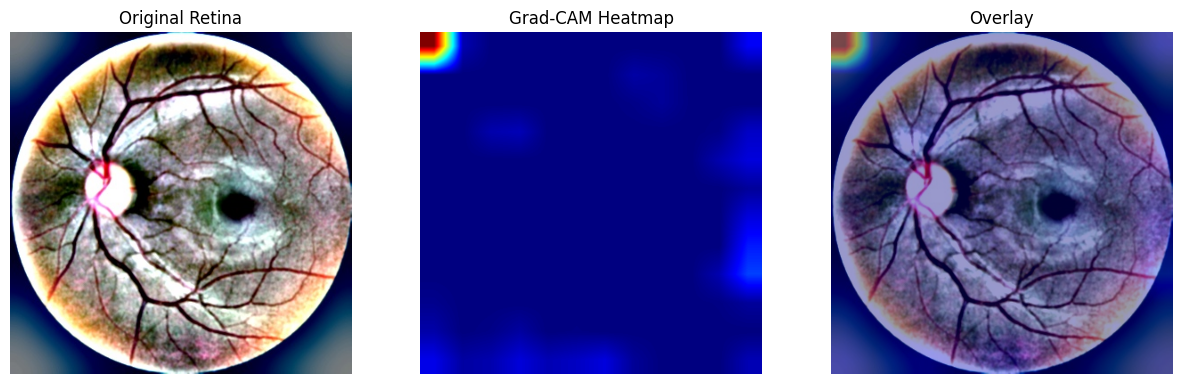

In [73]:
sample = val_df.iloc[0]["image_path"]

img, heatmap, overlay = generate_gradcam(sample)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Retina")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()



In [74]:
torch.save(model.state_dict(), "efficientnet_b3_final.pth")
print("Saved: efficientnet_b3_final.pth")


Saved: efficientnet_b3_final.pth


In [77]:
dummy_input = torch.randn(1, 3, 384, 384).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "efficientnet_b3.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=12,
    do_constant_folding=True
)

print("Saved: efficientnet_b3.onnx")


Saved: efficientnet_b3.onnx


In [78]:
import onnx

onnx_model = onnx.load("efficientnet_b3.onnx")
onnx.checker.check_model(onnx_model)

print("ONNX model verified.")


ONNX model verified.


In [80]:
import onnxruntime as ort

onnx_session = ort.InferenceSession("efficientnet_b3.onnx")

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

print("ONNX model loaded successfully.")
print("Input name:", input_name)
print("Output name:", output_name)


ONNX model loaded successfully.
Input name: input
Output name: output


In [81]:
def load_image_for_onnx(image_path):
    # load and preprocess (already preprocessed 384x384 jpg)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32") / 255.0

    # CHW
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)   # Add batch axis
    return img.astype(np.float32)


In [82]:
def predict_onnx(image_path):
    img_np = load_image_for_onnx(image_path)

    # Run inference
    pred_onxx = onnx_session.run([output_name], {input_name: img_np})[0]
    
    raw_value = float(pred_onxx.squeeze())
    pred_class = int(np.clip(round(raw_value), 0, 4))

    return raw_value, pred_class


In [84]:
sample_image = val_df.iloc[5]["image_path"]

# PyTorch prediction
pt_val, pt_class = predict_single(sample_image)

# ONNX prediction
onnx_val, onnx_class = predict_onnx(sample_image)

print("=== PyTorch vs ONNX Comparison ===")
print("PyTorch Raw:", pt_val)
print("PyTorch Predicted Class:", pt_class)
print()
print("ONNX Raw:", onnx_val)
print("ONNX Predicted Class:", onnx_class)


=== PyTorch vs ONNX Comparison ===
PyTorch Raw: 0.5226700305938721
PyTorch Predicted Class: 1

ONNX Raw: 0.5237061977386475
ONNX Predicted Class: 1


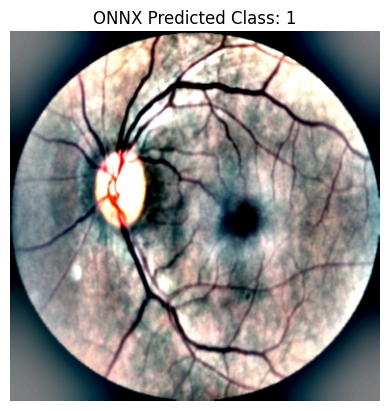

In [85]:
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"ONNX Predicted Class: {onnx_class}")
plt.axis("off")
plt.show()


In [88]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

# ======================================================
# 1. FUNDUS PREPROCESSING (same as training pipeline)
# ======================================================

IMG_SIZE = 384

def crop_black_borders(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is None:
        return img
    x, y, w, h = cv2.boundingRect(coords)
    return img[y:y+h, x:x+w]

def circle_crop(img):
    h, w = img.shape[:2]
    radius = min(h, w) // 2
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (w//2, h//2), radius, 255, -1)
    return cv2.bitwise_and(img, img, mask=mask)

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def preprocess_fundus_web(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image cannot be loaded: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # remove black borders
    img = crop_black_borders(img)

    # resize before circle crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = circle_crop(img)
    img = apply_clahe(img)

    # slight gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # brightness enhancement
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 30), -4, 128)

    # final resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    return img

# ======================================================
# 2. MODEL LOADING (EfficientNet-B3 regression)
# ======================================================

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EfficientNetB3Regression().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model, device

# ======================================================
# 3. PREDICT FUNCTION (input: raw image, output: DR grade)
# ======================================================

def predict_diabetic_retinopathy(image_path, model, device):
    # preprocess
    img = preprocess_fundus_web(image_path)

    # normalize + to tensor
    img_np = img.astype("float32") / 255.0
    img_np = np.transpose(img_np, (2, 0, 1))  # CHW
    img_tensor = torch.tensor(img_np).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).squeeze(0)

    raw_value = float(output.item())
    dr_class = int(np.clip(round(raw_value), 0, 4))

    return {
        "raw_score": raw_value,
        "predicted_class": dr_class,
        "preprocessed_image": img
    }


model, device = load_model("efficientnet_b3_final.pth")

result = predict_diabetic_retinopathy("dataset2/test_images/5b18feb15d84.png", model, device)

print("Raw Output:", result["raw_score"])
print("Predicted DR Class:", result["predicted_class"])



C:\Users\Adarsh Sharma\AppData\Local\Temp\ipykernel_52544\1894518141.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_lo

Raw Output: 1.9328922033309937
Predicted DR Class: 2
